In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#Matplotlib Settings
background_color = '#2b2130'
text_color = '#FFFFFF'
plt.rcParams.update({
    'axes.facecolor': background_color,  # Fondo del área de los ejes
    'axes.edgecolor': text_color,  # Color del borde de los ejes
    'axes.labelcolor': text_color,  # Color de las etiquetas de los ejes
    'xtick.color': text_color,  # Color de las marcas del eje x
    'ytick.color': text_color,  # Color de las marcas del eje y
    'text.color': text_color,  # Color del texto general
    'figure.facecolor': background_color,  # Color de fondo de la figura
    'figure.edgecolor': background_color,  # Color del borde de la figura
    'grid.color': text_color,  # Color de la cuadrícula
    'grid.linestyle': '--',  # Estilo de la línea de la cuadrícula
    'grid.linewidth': 0.5,  # Ancho de línea de la cuadrícula
    'legend.facecolor': background_color,  # Color de fondo de la leyenda
    'legend.edgecolor': text_color,  # Color del borde de la leyenda
})

colors = sns.color_palette('bright6')

print(colors)

[(0.00784313725490196, 0.24313725490196078, 1.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549), (0.9098039215686274, 0.0, 0.043137254901960784), (0.5450980392156862, 0.16862745098039217, 0.8862745098039215), (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)]


In [9]:
# Parámetros iniciales
f = 10  # frecuencia fundamental
dt = 1 / (100 * f)
t = np.arange(0, 20/f, dt)
s = np.cos(2 * np.pi * f * t + np.pi / 3) + np.sin(2 * np.pi * 2 * f * t + np.pi / 4)  # Señal "analógica"

# Muestreo de la señal
k = 2  # factor de muestreo 1.75 original
fs = k * (2 * f)  # frecuencia de muestreo
sf = round((1 / fs) / dt)  # factor de muestreo
sd = s[::sf]  # señal muestreada
td = t[::sf]  # soporte de la señal muestreada

# Proceso de cuantización lineal y codificación de las muestras
l = 6  # bit/palabra
Vp = max(abs(s))  # voltaje pico
DR = 2 * Vp  # rango dinámico
L = 2**l  # número de niveles
q = DR / L  # escalón
x = np.copy(sd)  # muestras
x[x > Vp] = Vp - q / 2  # saturación
x[x < -Vp] = -Vp + q / 2
Q = q * (np.floor(x / q) + 0.5)
nivel = ((Q - q / 2) / q + (L / 2)).astype(np.uint8)
cod = np.array([np.binary_repr(n, width=l) for n in nivel])

cat_cod = ''.join(cod)
bin_cod = np.array(list(cat_cod)).astype(int)
test = bin_cod[:80]




In [10]:
# Espectro de la señal
S = np.fft.fftshift(np.abs(np.fft.fft(s)) / len(s))
Fs = 1 / dt
f1 = np.linspace(-np.floor(Fs / 2), np.ceil(Fs / 2), len(s))
sd_upsampled = np.zeros(len(s))  # Crear un array de ceros para la señal muestreada
sd_upsampled[::sf] = sd  # Señal muestreada para calcular el espectro
Sd = np.fft.fftshift(np.abs(np.fft.fft(sd_upsampled)) / len(td))

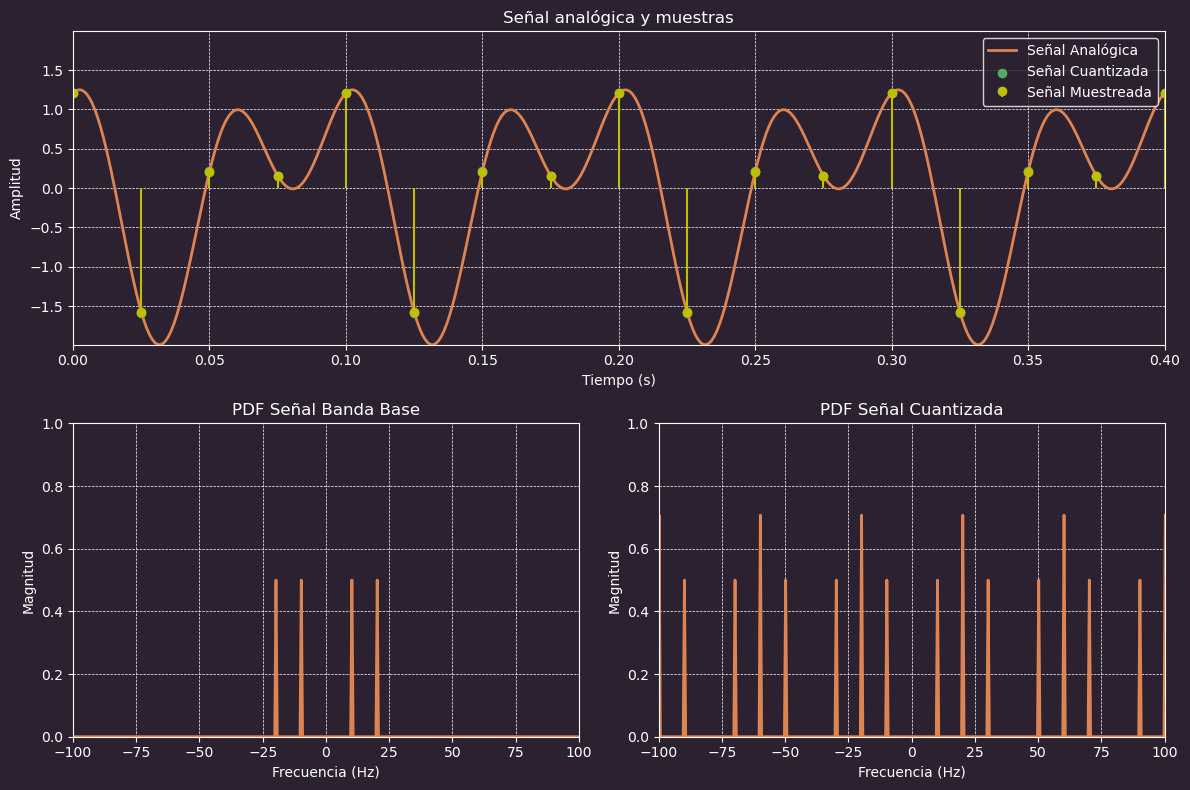

In [11]:
plt.figure(figsize=(12, 8)) 
plt.subplot(2, 2, (1, 2))
plt.plot(t, s, linewidth=2, label='Señal Analógica', color = colors[1])
plt.stem(td, sd, 'y*', label='Señal Muestreada', basefmt=" ")
plt.scatter(td, Q, color=colors[2], label='Señal Cuantizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal analógica y muestras')
plt.axis([0, 4/f, -Vp, Vp])
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(f1, S, linewidth=2, color = colors[1])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('PDF Señal Banda Base')
plt.grid()
plt.axis([-100, 100, 0, 1])

plt.subplot(2, 2, 4)
plt.plot(f1, Sd, linewidth=2, color = colors[1])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('PDF Señal Cuantizada')
plt.grid()
plt.axis([-100, 100, 0, 1])

plt.tight_layout()
plt.show()



In [12]:
# Definir las funciones de codificación
def RZ_s(h, bit_rate, duracion):
    n_bits = len(h)
    t_bit = 1 / bit_rate
    t_s = np.arange(0, duracion, t_bit / 100)  # Vector Tiempo
    s_s = np.zeros(len(t_s))  # Iniciar salida
    
    for i in range(n_bits):
        bit_i = i * t_bit  # Tiempo de inicio de bit actual
        bit_f = (i + 1) * t_bit - 0.5 * t_bit  # Tiempo final de bit actual
    
        if h[i] == 1:
            s_s[(t_s >= bit_i) & (t_s <= bit_f)] = 1  # Condición de voltaje alto
        else:
            s_s[(t_s >= bit_i) & (t_s <= bit_f)] = -1  # Condición de voltaje bajo
    
    return t_s, s_s

def NRZ_s(h, bit_rate, duracion):
    n_bits = len(h)
    t_bit = 1 / bit_rate
    t_s = np.arange(0, duracion, t_bit / 100)  # Vector Tiempo
    s_s = np.zeros(len(t_s))  # Inicializar salida
    
    for i in range(n_bits):
        bit_i = i * t_bit  # Tiempo de inicio del bit actual
        bit_f = (i + 1) * t_bit  # Tiempo final del bit actual
    
        if h[i] == 1:
            s_s[(t_s >= bit_i) & (t_s <= bit_f)] = 1  # Condición de voltaje alto
        else:
            s_s[(t_s >= bit_i) & (t_s <= bit_f)] = 0  # Condición de voltaje bajo
    
    return t_s, s_s

def RZ_AMI_s(h, bit_rate, duracion):
    n_bits = len(h)
    t_bit = 1 / bit_rate
    t_s = np.arange(0, duracion, t_bit / 100)  # Vector Tiempo
    s_s = np.zeros(len(t_s))  # Inicializar salida
    ultima_polaridad = 0  # Variable auxiliar para guardar última polaridad
    
    for i in range(n_bits):
        bit_i = i * t_bit + 0.25 * t_bit  # Tiempo de inicio del bit actual
        bit_f = (i + 1) * t_bit - 0.25 * t_bit  # Tiempo final del bit actual
    
        if h[i] == 1:
            if ultima_polaridad == 0:
                s_s[(t_s >= bit_i) & (t_s <= bit_f)] = 1  # Voltaje alto para '1'
                ultima_polaridad = 1
            else:
                s_s[(t_s >= bit_i) & (t_s <= bit_f)] = -1  # Polaridad invertida para '1' consecutivos
                ultima_polaridad = -1
        else:
            s_s[(t_s >= bit_i) & (t_s <= bit_f)] = 0  # Voltaje cero para '0'
            ultima_polaridad = 0
    
    return t_s, s_s

print(tes)

In [26]:
print(test)

[1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1
 0 0 1 1 0 0]


In [24]:
# Generar las señales codificadas
tx0, sx0 = RZ_s(test, 1000, 1)
tx1, sx1 = NRZ_s(test, 1000, 1)
tx2, sx2 = RZ_AMI_s(test, 1000, 1)

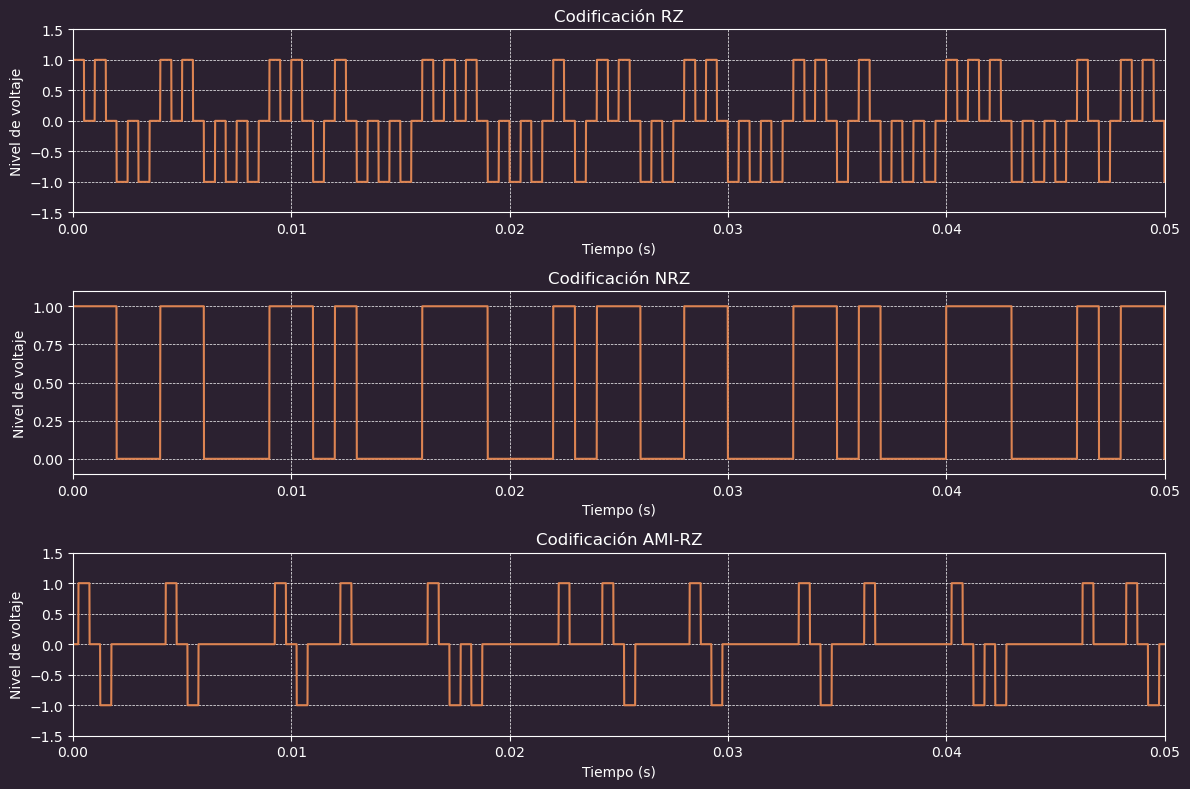

In [25]:
# Graficar las señales
plt.figure(figsize=(12, 8)) 

plt.subplot(3, 1, 1)
plt.plot(tx0, sx0, color=colors[1], linewidth=1.5)
plt.axis([0, 0.05, -1.5, 1.5])
plt.xlabel('Tiempo (s)')
plt.ylabel('Nivel de voltaje')
plt.title('Codificación RZ')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tx1, sx1, color=colors[1], linewidth=1.5)
plt.axis([0, 0.05, -0.1, 1.1])
plt.xlabel('Tiempo (s)')
plt.ylabel('Nivel de voltaje')
plt.title('Codificación NRZ')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tx2, sx2, color=colors[1], linewidth=1.5)
plt.axis([0, 0.05, -1.5, 1.5])
plt.xlabel('Tiempo (s)')
plt.ylabel('Nivel de voltaje')
plt.title('Codificación AMI-RZ')
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
import numpy as np

def mulaw(x, mu):
    """
    Function for mu-law compression for signals with maximum value of 1

    Inputs:
    x: input signal vector
    mu: compression parameter (mu=255 used for telephony)

    Output:
    y: mu-law encoded signal
    """
    sign = np.ones(len(x))
    sign[x <= 0] = -1
    y = (1 / np.log(1 + mu)) * np.log(1 + mu * np.abs(x)) * sign
    return y

def mulawinv(y, mu):
    """
    Function for inverse mu-law (expansion) for signal in the range [-1 1]

    Inputs:
    y: mu-law encoded input signal (usually quantized)
    mu: mulaw compression parameter

    Output:
    x: expanded output vector
    """
    y = np.array(y)
    sign = np.ones(len(y))
    sign[y <= 0] = -1
    x = (np.exp(np.abs(y) * np.log(1 + mu)) - 1) / mu * sign
    return x

def alaw(x, A):
    """
    Non-linear Quantization - A-law: A-law nonlinear quantization

    Inputs:
    x: input vector
    A: A-law compression parameter

    Output:
    C: A-law compressor output
    xmax: maximum of input vector x
    """
    x = np.array(x)
    xmax = np.max(np.abs(x))
    C = np.zeros_like(x, dtype=float)
    
    for i in range(len(x)):
        abs_val = np.abs(x[i] / xmax)
        if 0 < abs_val <= 1 / A:
            C[i] = A * abs_val / (1 + np.log(A))
        elif 1 / A < abs_val <= 1:
            C[i] = (1 + np.log(A * abs_val)) / (1 + np.log(A))
    
    C = C * np.sign(x) / xmax
    return C, xmax

def inavalaw(C, A):
    """
    Non-linear Quantization - A-law: A-law nonlinear quantization expansion

    Inputs:
    C: A-law compressed input vector
    A: A-law compression parameter

    Output:
    x: A-law expanded output vector
    xmax: maximum of input vector x
    """
    C = np.array(C)
    xmax = np.max(np.abs(C))
    x = np.zeros_like(C, dtype=float)
    
    for i in range(len(C)):
        abs_val = np.abs(C[i] / xmax)
        if 0 < abs_val <= 1 / (1 + np.log(A)):
            x[i] = (abs_val * (1 + np.log(A))) / A
        elif 1 / (1 + np.log(A)) < abs_val <= 1:
            x[i] = np.exp(abs_val * (1 + np.log(A)) - 1) / A
    
    x = x * np.sign(C) * xmax
    return x

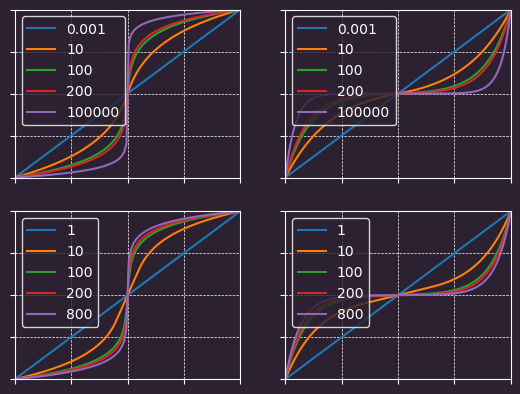

In [16]:
n = np.linspace(-1, 1, 100)
mus = [0.001, 10, 100, 200, int(10e4)]
Aco = [1, 10, 100, 200, 800]


plt.subplot(221)
for mu in mus:
    n_mu = mulaw(n, mu)
    plt.plot(n, n_mu)

plt.axis([-1, 1, -1, 1])
plt.legend(mus)
plt.grid()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.subplot(222)
for mu in mus:
    n_mu = mulawinv(n, mu)
    plt.plot(n, n_mu)

plt.axis([-1, 1, -1, 1])
plt.legend(mus)
plt.grid()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.subplot(223)
for A in Aco:
    n_A, x_max = alaw(n, A)
    plt.plot(n, n_A)

plt.axis([-1, 1, -1, 1])
plt.legend(Aco)
plt.grid()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])


plt.subplot(224)
for A in Aco:
    n_A = inavalaw(n, A)
    plt.plot(n, n_A)

plt.axis([-1, 1, -1, 1])
plt.legend(Aco)
plt.grid()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])



plt.show()

In [17]:
print("Modulación por codificación de pulso")
print(f"Frecuencia de muestreo fs = {k:.2f} fmax")
print(f"Cuantizador lineal con L = {L:3d} niveles\n")

print(f"{'x(t)':>10} {'Q(x)':>10} {'Nivel':>6} {'PCMcode':>9}")
for i in range(len(x)):
    print(f"{str(f'{x[i]:8.6f}'):>10} {str(f'{Q[i]:8.6f}'):>10} {str(f'{nivel[i]:3d}'):>6} {str(f'{cod[i]:6s}'):>9}")

print("\n")

Modulación por codificación de pulso
Frecuencia de muestreo fs = 2.00 fmax
Cuantizador lineal con L =  64 niveles

      x(t)       Q(x)  Nivel   PCMcode
  1.207107   1.213908     51    110011
 -1.573132  -1.587419      6    000110
  0.207107   0.217881     35    100011
  0.158919   0.155629     34    100010
  1.207107   1.213908     51    110011
 -1.573132  -1.587419      6    000110
  0.207107   0.217881     35    100011
  0.158919   0.155629     34    100010
  1.207107   1.213908     51    110011
 -1.573132  -1.587419      6    000110
  0.207107   0.217881     35    100011
  0.158919   0.155629     34    100010
  1.207107   1.213908     51    110011
 -1.573132  -1.587419      6    000110
  0.207107   0.217881     35    100011
  0.158919   0.155629     34    100010
  1.207107   1.213908     51    110011
 -1.573132  -1.587419      6    000110
  0.207107   0.217881     35    100011
  0.158919   0.155629     34    100010
  1.207107   1.213908     51    110011
 -1.573132  -1.587419      

In [18]:
print(bin_cod)

[1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1
 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0
 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0
 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1
 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1
 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1
 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0
 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0
 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1
 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1
 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0
 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0]
